In [2]:
import pandas as pd

from IPython.display import display
import numpy as np
import visuals as vs
%matplotlib inline
pd.set_option('display.max_colwidth', -1)

# prediction_dt is 1 month ahead of active_as_of_dt and they should be month-ends
def get_customer_status(prediction_dt, active_as_of_dt):
    #df = spark.read.format("csv").option("header", "true").option("delimiter", "\t").load("customer_status_history_train.csv.gz")
    df = pd.read_csv("customer_status_history_train.csv",sep='\t')
    #status = df.filter(df.snapshot_day <= prediction_dt).toPandas()
    status = df[df['snapshot_day']<=prediction_dt]
    status.snapshot_day = pd.to_datetime(status.snapshot_day, format='%Y-%m-%d')
    prior_month = status[status.snapshot_day <= active_as_of_dt].groupby('customer_id')
    # pick the last status of the month
    xr = prior_month.last()

#     res = prior_month['snapshot_day'].agg({'enter': 'first', 'exit': 'last'})

#     res['time_diff'] = res['exit'] - res['enter']
    
    active_customers = xr[xr.ku_status == 'PAID ACTIVE'].index
    
#     print res.columns.values
    prediction_month = status[status.snapshot_day <= prediction_dt].groupby('customer_id')
    # set the last status of the month (in case the status flipped within the month)
    xr = prediction_month.last()
    
#     completedf = pd.merge(xr, res, left_index=True, right_index=True, how="right")

#     completedf.time_diff = completedf.time_diff.dt.days
    
#     completedf.drop(['enter','exit'], axis=1, inplace=True)
    
    prediction_month_status = xr[xr.index.isin(active_customers)]
    
    return prediction_month_status


In [3]:
status = get_customer_status('2017-08-31', '2017-07-31')
status.head(5)

,snapshot_day,ku_status
customer_id,,
00012d5c5b3caba6486bf760f154a1a1310603a87a233982f19365ed4af4b60f,2017-08-10,PAID CANCELLED
000151374577dd6fe194237e23627f83541bcc39926089d7f63bc041c7fafe67,2017-08-24,PAID CANCELLED
00015215c16e4586578b42c2ee8535cbcec8e93bf2b62c78dfcbc059573d58b1,2017-02-01,PAID ACTIVE
000152eaa0928969c1da93e930e2944698e21594729f6ae7182e8cda46233c46,2017-08-20,PAID CANCELLED
0001d4efe1974e3d822ebed0ac4bc05cf85da8a8b61d839a504b9c3d92c4f53b,2017-05-12,PAID ACTIVE


In [116]:
def getNumActiveDays(endDate):
    df = pd.read_csv("customer_status_history_train.csv",sep='\t')
    #status = df.filter(df.snapshot_day <= prediction_dt).toPandas()
    statusA = df[df['snapshot_day']<=endDate]
    statusA.snapshot_day = pd.to_datetime(statusA.snapshot_day, format='%Y-%m-%d')
    statusvals = statusA.groupby(['customer_id','ku_status']).size()
    
#     paidCancelled = statusvals['00006cbd025f7b0b3f894b319efccde84f1b059bf7b76f0a44de15e6fd19e82e','PAID CANCELLED']
#     total = statusvals['00006cbd025f7b0b3f894b319efccde84f1b059bf7b76f0a44de15e6fd19e82e','PAID ACTIVE'] + statusvals['00006cbd025f7b0b3f894b319efccde84f1b059bf7b76f0a44de15e6fd19e82e','PAID CANCELLED']
    
    prior_month = statusA.groupby('customer_id')
    numSnaps = prior_month.size()
    xr = prior_month.last()
#     xr[xr.ku_status == 'PAID ACTIVE'].index
    xr['ku_status'] = xr['ku_status'].map({'PAID ACTIVE': 1, 'PAID CANCELLED': 0})
    
#     xr.head(15)
    cancelledRatio = []
    snapVals = []
    statusvals.head(10)
    j=0
    for i, row in xr.iterrows():
        try:
            paidCancelled = statusvals[i,'PAID CANCELLED']
        except KeyError:
            paidCancelled = 0
        try:
            paidActive = statusvals[i,'PAID ACTIVE']
        except KeyError:
            paidActive = 0
        total = paidActive + paidCancelled
        snaps = numSnaps[i]
        snapVals.append(snaps)
        cancelledRatio.append(float(paidCancelled)/float(total))

    se = pd.Series(cancelledRatio)
    xr['cancelledRatio'] = se.values
    se = pd.Series(snapVals)
    xr['snapVals'] = se.values
    xr.head(10)
    
# #     print prior_month.head(20).to_string()
    res = prior_month['snapshot_day'].agg({'enter': 'first', 'exit': 'last'})

    res['time_diff'] = res['exit'] - res['enter']

    res.time_diff = res.time_diff.dt.days
    
    res.drop(['enter','exit'], axis=1, inplace=True)
             
    timeAndLast = pd.merge(res,xr, right_index=True, left_index=True, how="left")
    
    timeAndLast.drop(['snapshot_day'], axis=1, inplace=True)
    
    timeAndLast.rename(columns={'ku_status': 'last_status'}, inplace=True)
    
    
    return timeAndLast
#     return prior_month.size()
    
    
    

In [107]:
custActiveDays = getNumActiveDays('2017-08-31')
custActiveDays.head(10)
# listof = custActiveDays['customer_id'].values
# dfList = custActiveDays['customer_id'].tolist()
# for customer in dfList:
#     custActiveDays[customer,'PAID ACTIVE']
#     custActiveDays[customer,'PAID CANCELLED']
# custActiveDays['00006cbd025f7b0b3f894b319efccde84f1b059bf7b76f0a44de15e6fd19e82e','PAID ACTIVE'] + custActiveDays['00006cbd025f7b0b3f894b319efccde84f1b059bf7b76f0a44de15e6fd19e82e','PAID CANCELLED']

C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


,time_diff,last_status,cancelledRatio
customer_id,,,
00006cbd025f7b0b3f894b319efccde84f1b059bf7b76f0a44de15e6fd19e82e,215,0,0.600000
0000dfb1ac7e6ffb2e8f0f4e14271afa87cf0c5cddc030916709d13ef1763d76,0,1,0.000000
0000e2aee8f9a5f294b1d8f765c8848e00eb051cc4faaa3ab4eb75c879dbcb7b,187,0,0.555556
0000f6dbd168a7b51a238b6a2ffbc66f7c097bda5326d48ac076e207a89b5ff1,0,1,0.000000
000112ee1dbd72cede2d7e0b62eb010ba97bb6ec12eac83328b545f11c434f2b,249,0,0.444444
00012d5c5b3caba6486bf760f154a1a1310603a87a233982f19365ed4af4b60f,46,0,0.250000
000151374577dd6fe194237e23627f83541bcc39926089d7f63bc041c7fafe67,380,0,0.500000
00015215c16e4586578b42c2ee8535cbcec8e93bf2b62c78dfcbc059573d58b1,33,1,0.000000
000152eaa0928969c1da93e930e2944698e21594729f6ae7182e8cda46233c46,243,0,0.400000


In [187]:
df = pd.read_csv("customer_reading_history.csv",sep='\t')

In [114]:
df = pd.read_csv("customer_status_history_train.csv",sep='\t')
    #status = df.filter(df.snapshot_day <= prediction_dt).toPandas()
statusA = df[df['snapshot_day']<='2017-08-31']
statusA.snapshot_day = pd.to_datetime(statusA.snapshot_day, format='%Y-%m-%d')
statusvals = statusA.groupby(['customer_id','ku_status']).size()
    
# paidCancelled = statusvals['00006cbd025f7b0b3f894b319efccde84f1b059bf7b76f0a44de15e6fd19e82e','PAID CANCELLED']
# total = statusvals['00006cbd025f7b0b3f894b319efccde84f1b059bf7b76f0a44de15e6fd19e82e','PAID ACTIVE'] + statusvals['00006cbd025f7b0b3f894b319efccde84f1b059bf7b76f0a44de15e6fd19e82e','PAID CANCELLED']
    
prior_month = statusA.groupby('customer_id')
numSnaps = prior_month.size()
xr = prior_month.last()
#     xr[xr.ku_status == 'PAID ACTIVE'].index
# xr['ku_status'] = xr['ku_status'].map({'PAID ACTIVE': 1, 'PAID CANCELLED': 0})
xr.head(15)
cancelledRatio = []
snapVals = []
statusvals.head(10)
j=0
for i, row in xr.iterrows():
    try:
        paidCancelled = statusvals[i,'PAID CANCELLED']
    except KeyError:
        paidCancelled = 0
    try:
        paidActive = statusvals[i,'PAID ACTIVE']
    except KeyError:
        paidActive = 0
    total = paidActive + paidCancelled
    
    snaps = numSnaps[i]
    snapVals.append(snaps)
    cancelledRatio.append(float(paidCancelled)/float(total))

se = pd.Series(cancelledRatio)
xr['cancelledRatio'] = se.values
se = pd.Series(snapVals)
xr['snapVals'] = se.values
xr.head(10)


,snapshot_day,ku_status,cancelledRatio,snapVals
customer_id,,,,
00006cbd025f7b0b3f894b319efccde84f1b059bf7b76f0a44de15e6fd19e82e,2017-07-27,PAID CANCELLED,0.600000,5
0000dfb1ac7e6ffb2e8f0f4e14271afa87cf0c5cddc030916709d13ef1763d76,2017-08-01,PAID ACTIVE,0.000000,1
0000e2aee8f9a5f294b1d8f765c8848e00eb051cc4faaa3ab4eb75c879dbcb7b,2017-08-21,PAID CANCELLED,0.555556,9
0000f6dbd168a7b51a238b6a2ffbc66f7c097bda5326d48ac076e207a89b5ff1,2017-08-06,PAID ACTIVE,0.000000,1
000112ee1dbd72cede2d7e0b62eb010ba97bb6ec12eac83328b545f11c434f2b,2017-05-18,PAID CANCELLED,0.444444,9
00012d5c5b3caba6486bf760f154a1a1310603a87a233982f19365ed4af4b60f,2017-08-10,PAID CANCELLED,0.250000,4
000151374577dd6fe194237e23627f83541bcc39926089d7f63bc041c7fafe67,2017-08-24,PAID CANCELLED,0.500000,2
00015215c16e4586578b42c2ee8535cbcec8e93bf2b62c78dfcbc059573d58b1,2017-02-01,PAID ACTIVE,0.000000,3
000152eaa0928969c1da93e930e2944698e21594729f6ae7182e8cda46233c46,2017-08-20,PAID CANCELLED,0.400000,5


In [7]:
import pandas as pd
def get_customer_activity_features(month_end_dt):
    # Read the purchase history file in
    # ph = spark.read.format("csv").option("header", "true").option("delimiter", "\t").load("customer_purchase_history.csv.gz")
    ph = pd.read_csv("customer_purchase_history.csv",sep='\t')
    data = ph[ph['snapshot_day']==month_end_dt]
    cust_features = data[['customer_id', 'paid_units_mtd', 'ku_loans_t7', 'ku_loans_mtd', 'free_units_mtd', 'pbook_units_mtd']]
    # Cheat by filtering on the month end summary record. Pick only paid units and ku loans month-to-date
    #cust_features = ph.filter(ph.snapshot_day == month_end_dt).select(['customer_id', 'paid_units_mtd', 'ku_loans_t7', 'ku_loans_mtd', 'free_units_mtd', 'pbook_units_mtd']).toPandas()
    # Convert to integer type
    cust_features.paid_units_mtd = cust_features.paid_units_mtd.astype(int)
    cust_features.ku_loans_mtd = cust_features.ku_loans_mtd.astype(int)
    cust_features.ku_loans_t7 = cust_features.ku_loans_t7.astype(int)
    cust_features.free_units_mtd = cust_features.free_units_mtd.astype(int)
    cust_features.pbook_units_mtd = cust_features.pbook_units_mtd.astype(int)
    return cust_features
    # cust_features[(cust_features.paid_units_mtd != 0) & (cust_features.ku_loans_mtd != 0)].count()


In [186]:
frame1 = get_customer_activity_features('2017-07-31')
print frame1.shape
frame1.index = frame1.customer_id
frame1 = frame1.drop('customer_id', axis=1)

frame2 = get_customer_activity_features('2017-06-30')
print frame2.shape

frame2.index = frame2.customer_id
frame2 = frame2.drop('customer_id', axis=1)

frame2.rename(columns={'paid_units_mtd': 'paid_units_mtd_june', 'ku_loans_t7': 'ku_loans_t7_june', 'ku_loans_mtd': 'ku_loans_mtd_june', 'free_units_mtd': 'free_units_mtd_june', 'pbook_units_mtd': 'pbook_units_mtd_june'}, inplace=True)

frame1 = pd.merge(frame1, frame2 , left_index=True, right_index=True, how="outer")
frame1.head(3)
# print frame1.shape
# frame1.fillna(0, inplace=True)

(135985, 6)
(128396, 6)


,paid_units_mtd,ku_loans_t7,ku_loans_mtd,free_units_mtd,pbook_units_mtd,paid_units_mtd_june,ku_loans_t7_june,ku_loans_mtd_june,free_units_mtd_june,pbook_units_mtd_june
customer_id,,,,,,,,,,
00006cbd025f7b0b3f894b319efccde84f1b059bf7b76f0a44de15e6fd19e82e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0000e2aee8f9a5f294b1d8f765c8848e00eb051cc4faaa3ab4eb75c879dbcb7b,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
000112ee1dbd72cede2d7e0b62eb010ba97bb6ec12eac83328b545f11c434f2b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
raw_data = {
        'subject_id': ['1', '2', '3', '4', '5'],
        'first_name': ['Alex', 'Amy', 'Allen', 'Alice', 'Ayoung'], 
        'last_name': ['Anderson', 'Ackerman', 'Ali', 'Aoni', 'Atiches']}
df_a = pd.DataFrame(raw_data, columns = ['subject_id', 'first_name', 'last_name'])
df_a.index = df_a.subject_id
df_a = df_a.drop('subject_id', axis=1)
df_a

raw_data = {
        'subject_id': ['4', '5', '6', '7', '8'],
        'second_name': ['Billy', 'Brian', 'Bran', 'Bryce', 'Betty'], 
        'no_name': ['Bonder', 'Black', 'Balwner', 'Brice', 'Btisan']}
df_b = pd.DataFrame(raw_data, columns = ['subject_id', 'second_name', 'no_name'])
df_b.index = df_b.subject_id
df_b = df_b.drop('subject_id', axis=1)
df_b

finalpd = pd.merge(df_a, df_b, right_index=True, left_index=True, how="right")
finalpd.fillna('Vivek', inplace=True)
finalpd

,first_name,last_name,second_name,no_name
subject_id,,,,
4,Alice,Aoni,Billy,Bonder
5,Ayoung,Atiches,Brian,Black
6,Vivek,Vivek,Bran,Balwner
7,Vivek,Vivek,Bryce,Brice
8,Vivek,Vivek,Betty,Btisan


In [8]:
def get_customer_device_features(month_end_dt):
    # Read the device history file in
    # dh = spark.read.format("csv").option("header", "true").option("delimiter", "\t").load("customer_device_history.csv.gz")
    dh = pd.read_csv("customer_device_history.csv",sep='\t')
    data = dh[dh['snapshot_day']<= month_end_dt]
    cust_features = data[['snapshot_day', 'customer_id', 'active_android', 'active_kcp', 'active_ios', 'active_kcr', 'active_tablet', 'active_eink', 'active_phone']]
    # Convert to integer type
    #cust_features.active_android = cust_features.active_android.astype(float)
    
    #cust_features.active_android.fillna(0, inplace=True)
    #cust_features.active_android = cust_features.active_android.astype(int)
    #cust_features = cust_features.groupby('customer_id')['active_android'].last()
    
    #cust_features = pd.Series.to_frame(cust_features)
#     cust_features.head(10)
    cust_features['num_active'] = cust_features.sum(axis=1)
    
    cust_features.num_active = cust_features.num_active.astype(float)
    cust_features.num_active.fillna(0, inplace=True)
    cust_features.num_active = cust_features.num_active.astype(int)
    cust_features = cust_features.groupby('customer_id')['num_active'].last()
    return cust_features
    # cust_features[(cust_features.paid_units_mtd != 0) & (cust_features.ku_loans_mtd != 0)].count()

# device_counts = get_customer_device_features('2017-08-31')
# device_counts.head()

In [9]:
device_counts = get_customer_device_features('2017-07-31')
device_counts.head(3)

customer_id
00006cbd025f7b0b3f894b319efccde84f1b059bf7b76f0a44de15e6fd19e82e    2
0000dfb1ac7e6ffb2e8f0f4e14271afa87cf0c5cddc030916709d13ef1763d76    2
0000e2aee8f9a5f294b1d8f765c8848e00eb051cc4faaa3ab4eb75c879dbcb7b    3
Name: num_active, dtype: int32

In [10]:
# Normalize

# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
def getNormalizedFeatures(feas):
    scaler = MinMaxScaler() # default=(0, 1)
    numerical = []
    for feature in feas.keys():
        numerical = numerical + [feature]
    if 'status' in numerical:
        numerical.remove('status')
    if 'Intercept' in numerical:
        numerical.remove('Intercept')
        
#     numerical = ['paid_units_mtd','ku_loans_t7','ku_loans_mtd','free_units_mtd','pbook_units_mtd','paid_units_mtd_june','ku_loans_t7_june','ku_loans_mtd_june','free_units_mtd_june','pbook_units_mtd_june','num_active','time_diff']
#     numerical2 = ['paid_units_mtd_may','ku_loans_t7_may','ku_loans_mtd_may','free_units_mtd_may','pbook_units_mtd_may']
#     numerical3 = ['paid_units_mtd_apr','ku_loans_t7_apr','ku_loans_mtd_apr','free_units_mtd_apr','pbook_units_mtd_apr']
#     numerical = numerical + numerical2 + numerical3
    features_log_minmax_transform = pd.DataFrame(data = feas)
    features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_minmax_transform[numerical])
    return features_log_minmax_transform

# Show an example of a record with scaling applied
# features_log_minmax_transform.head(n = 5)

In [11]:
def removeOutliers(features):
    
    features_after_removing_outliers = features.copy()
    for feature in features.keys():

        if feature == 'status':
            continue
        # TODO: Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(features[feature],25)

        # TODO: Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(features[feature],75)

        # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = (Q3-Q1)*1.5

        # Display the outliers
        #print "Data points considered outliers for the feature '{}':".format(feature)
        features_after_removing_outliers.drop(features[~((features[feature] >= Q1 - step) & (features[feature] <= Q3 + step))].index)
    return features_after_removing_outliers
# OPTIONAL: Select the indices for data points you wish to remove
# outliers  = [75,154,66]

# # Remove the outliers, if any were specified
# good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

In [ ]:
# Code to save intermediate data frames to CSV
# from io import BytesIO
# import boto3
# from boto3.session import Session

# # To be used in eider workspace only (references variables provided by eider)
# def write_to_s3(df, bucket, key):
#     session = Session(aws_access_key_id=awsAccessKeyId, aws_secret_access_key=awsSecretKey)
#     s3_resource = session.resource("s3")
#     csv_buffer = BytesIO()
#     df.to_csv(csv_buffer)
#     # s3_resource.Object('emr-eldorado', 'cust_features.csv').put(Body=csv_buffer.getvalue())
#     s3_resource.Object(bucket, username + "/" + key).put(Body=csv_buffer.getvalue())

In [12]:
def getActivityFeatures(date,suffix = ""):
    dftemp = get_customer_activity_features(date)
    dftemp.index = dftemp.customer_id
    dftemp = dftemp.drop('customer_id', axis=1)
    if suffix!="":
        dftemp.rename(columns={'paid_units_mtd': 'paid_units_mtd_'+suffix, 'ku_loans_t7': 'ku_loans_t7_'+suffix, 'ku_loans_mtd': 'ku_loans_mtd_'+suffix, 'free_units_mtd': 'free_units_mtd_'+suffix, 'pbook_units_mtd': 'pbook_units_mtd_'+suffix}, inplace=True)

    return dftemp

In [141]:
fes = getActivityFeatures('2017-07-31')

y = getActivityFeatures('2017-06-30',"monthminus1")
fes = pd.merge(fes, y , left_index=True, right_index=True, how="outer")

z = getActivityFeatures('2017-05-31', "monthminus2")
fes = pd.merge(fes, z , left_index=True, right_index=True, how="outer")

y = getActivityFeatures('2017-04-30', "monthminus3")
fes = pd.merge(fes, y , left_index=True, right_index=True, how="outer")

z = getActivityFeatures('2017-03-31', "monthminus4")
fes = pd.merge(fes, z , left_index=True, right_index=True, how="outer")

y = getActivityFeatures('2017-02-28', "monthminus5")
fes = pd.merge(fes, y , left_index=True, right_index=True, how="outer")

print fes.shape

(137725, 30)


In [147]:
feas = fes.copy()
numDaysAndLast = getNumActiveDays('2017-07-31')
feas = pd.merge(feas,numDaysAndLast , left_index=True, right_index=True, how="left")

status = get_customer_status('2017-08-31', '2017-07-31')
print feas.shape
status.head(5)
feas =  feas[feas.index.isin(status.index)]
feas['status'] = status[status.index.isin(feas.index)]['ku_status']
# x['num_days'] = status[status.index.isin(x.index)]['time_diff']
# df1 = status[['time_diff']]
# x = pd.merge(x,df1 , left_index=True, right_index=True, how="left")
print feas.shape
device_counts = get_customer_device_features('2017-07-31')
#x['active_android'] = device_counts[device_counts.index.isin(x.index)]
feas['num_active'] = device_counts[device_counts.index.isin(feas.index)]
print feas.shape
feas = removeOutliers(feas)
print feas.shape

C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:43: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


(137725, 34)
(65521, 35)
(65521, 36)
(65521, 36)


In [161]:
x=feas.copy()
print x.shape
tempdf = x[['status']]

x.fillna(0, inplace=True)

# x['diffm5tom4kuloans'] = x['ku_loans_mtd_monthminus5'] + x['paid_units_mtd_monthminus5'] + x['free_units_mtd_monthminus5'] + x['pbook_units_mtd_monthminus5'] - x['ku_loans_mtd_monthminus4'] - x['paid_units_mtd_monthminus4'] - x['free_units_mtd_monthminus4'] - x['pbook_units_mtd_monthminus4']
# x['diffm4tom3kuloans'] = x['ku_loans_mtd_monthminus4']  + x['paid_units_mtd_monthminus4'] + x['free_units_mtd_monthminus4'] + x['pbook_units_mtd_monthminus4']- x['ku_loans_mtd_monthminus3'] - x['paid_units_mtd_monthminus3'] - x['free_units_mtd_monthminus3'] - x['pbook_units_mtd_monthminus3']
# x['diffm3tom2kuloans'] = x['ku_loans_mtd_monthminus3']  + x['paid_units_mtd_monthminus3'] + x['free_units_mtd_monthminus3'] + x['pbook_units_mtd_monthminus3']- x['ku_loans_mtd_monthminus2'] - x['paid_units_mtd_monthminus2'] - x['free_units_mtd_monthminus2'] - x['pbook_units_mtd_monthminus2']
# x['diffm2tom1kuloans'] = x['ku_loans_mtd_monthminus2']  + x['paid_units_mtd_monthminus2'] + x['free_units_mtd_monthminus2'] + x['pbook_units_mtd_monthminus2']- x['ku_loans_mtd_monthminus1'] - x['paid_units_mtd_monthminus1'] - x['free_units_mtd_monthminus1'] - x['pbook_units_mtd_monthminus1']
# x['diffm1tom0kuloans'] = x['ku_loans_mtd_monthminus1']  + x['paid_units_mtd_monthminus1'] + x['free_units_mtd_monthminus1'] + x['pbook_units_mtd_monthminus1']- x['ku_loans_mtd'] - x['paid_units_mtd'] - x['free_units_mtd'] - x['pbook_units_mtd']

x['diffm5tom4kuloans'] = x['ku_loans_mtd_monthminus5'] - x['ku_loans_mtd_monthminus4']
x['diffm4tom3kuloans'] = x['ku_loans_mtd_monthminus4'] - x['ku_loans_mtd_monthminus3']
x['diffm3tom2kuloans'] = x['ku_loans_mtd_monthminus3'] - x['ku_loans_mtd_monthminus2']
x['diffm2tom1kuloans'] = x['ku_loans_mtd_monthminus2'] - x['ku_loans_mtd_monthminus1']
x['diffm1tom0kuloans'] = x['ku_loans_mtd_monthminus1'] - x['ku_loans_mtd']

x['diffm5tom4freeunits'] = x['free_units_mtd_monthminus5'] - x['free_units_mtd_monthminus4']
x['diffm4tom3freeunits'] = x['free_units_mtd_monthminus4'] - x['free_units_mtd_monthminus3']
x['diffm3tom2freeunits'] = x['free_units_mtd_monthminus3'] - x['free_units_mtd_monthminus2']
x['diffm2tom1freeunits'] = x['free_units_mtd_monthminus2'] - x['free_units_mtd_monthminus1']
x['diffm1tom0freeunits'] = x['free_units_mtd_monthminus1'] - x['free_units_mtd']

x = getNormalizedFeatures(x)
print x.shape
x['status'] = tempdf[['status']]
# x['Intercept'] = tempdf[['Intercept']]
print x.shape
x.head(5)
# write_to_s3(x, 'ml-hack-subs-data', 'prepared-dataset-2017-08-31.csv')

(65521, 36)
(65521, 46)
(65521, 46)


,paid_units_mtd,ku_loans_t7,ku_loans_mtd,free_units_mtd,pbook_units_mtd,paid_units_mtd_monthminus1,ku_loans_t7_monthminus1,ku_loans_mtd_monthminus1,free_units_mtd_monthminus1,pbook_units_mtd_monthminus1,...,diffm5tom4kuloans,diffm4tom3kuloans,diffm3tom2kuloans,diffm2tom1kuloans,diffm1tom0kuloans,diffm5tom4freeunits,diffm4tom3freeunits,diffm3tom2freeunits,diffm2tom1freeunits,diffm1tom0freeunits
customer_id,,,,,,,,,,,,,,,,,,,,,
00012d5c5b3caba6486bf760f154a1a1310603a87a233982f19365ed4af4b60f,0.000000,0.000000,0.000992,0.000000,0.000000,0.000000,0.003484,0.001055,0.000000,0.000000,...,0.589194,0.410806,0.720461,0.369538,0.782994,0.413748,0.586252,0.670376,0.351271,0.618799
000151374577dd6fe194237e23627f83541bcc39926089d7f63bc041c7fafe67,0.000000,0.000000,0.000000,0.000000,0.000000,0.007299,0.000000,0.000000,0.000000,0.038961,...,0.589194,0.410806,0.720461,0.370787,0.782994,0.413748,0.586252,0.670376,0.351271,0.618799
00015215c16e4586578b42c2ee8535cbcec8e93bf2b62c78dfcbc059573d58b1,0.020619,0.001055,0.000992,0.000000,0.006849,0.021898,0.003484,0.009494,0.001451,0.000000,...,0.589194,0.410806,0.721182,0.360799,0.790080,0.416342,0.583658,0.671766,0.350523,0.620104
000152eaa0928969c1da93e930e2944698e21594729f6ae7182e8cda46233c46,0.000000,0.003165,0.010913,0.006329,0.000000,0.000000,0.000000,0.002110,0.000000,0.012987,...,0.596913,0.403087,0.727666,0.368290,0.775022,0.413748,0.586252,0.670376,0.351271,0.614883
0001d4efe1974e3d822ebed0ac4bc05cf85da8a8b61d839a504b9c3d92c4f53b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.589194,0.410806,0.720461,0.370787,0.782994,0.413748,0.586252,0.670376,0.351271,0.618799


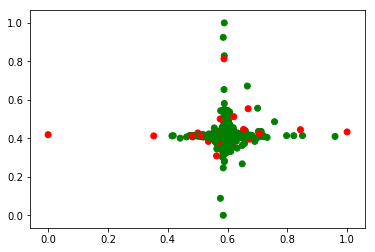

In [163]:
# dfcopy = x.copy()
# dfcopy['status'] = dfcopy['status'].map({'PAID ACTIVE': 1, 'PAID CANCELLED': 0})
# # for column in dfcopy:
# #     if column == 'status':
# #         continue
# dfcopy.plot(x='snapVals', y='cancelledRatio', style='o')
x1 = x['snapVals'].tolist()
x2 = x['cancelledRatio'].tolist()
dfcopy['status'] = x['status'].map({'PAID ACTIVE': 1, 'PAID CANCELLED': 0})
target = dfcopy['status'].tolist()
# print target
color= ['red' if l == 0 else 'green' for l in target]
# print(len(X_train),len(X_test),len(Xs))
# plt.figure()
# plt.scatter(x1, x2, color=color)
# print len(target)

# x1 = x['ku_loans_t7'].tolist()
# x2 = x['ku_loans_mtd'].tolist()
# plt.figure()
# plt.scatter(x1, x2, color=color)

# plt.figure()
# plt.scatter(x['num_active'].tolist(), x['time_diff'].tolist(), color=color)
plt.figure()
plt.scatter(x['diffm5tom4kuloans'].tolist(), x['diffm5tom4freeunits'].tolist(), color=color)

In [ ]:
ax_list=pd.DataFrame.hist(x,['paid_units_mtd','ku_loans_t7','ku_loans_mtd','free_units_mtd','pbook_units_mtd','time_diff'],figsize =(15,15))
ax_list[0][0].set_xlim((0,100))
ax_list[0][0].set_ylim((60000,70000))
ax_list[0][1].set_xlim((0,200))
ax_list[0][1].set_ylim((60000,70000))
ax_list[1][0].set_xlim((0,200))
ax_list[1][0].set_ylim((60000,70000))
ax_list[1][1].set_xlim((0,20))
ax_list[2][0].set_xlim((0,50))
ax_list[2][0].set_ylim((60000,70000))
ax_list[2][1].set_xlim((0,50))
ax_list[2][1].set_ylim((60000,70000))

# I don't see anything skewed

In [183]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

df = x[(x.status == 'PAID ACTIVE') | (x.status == 'PAID CANCELLED')]
df.head(5)
# target, features = dmatrices('status ~ paid_units_mtd + ku_loans_mtd + free_units_mtd + pbook_units_mtd + num_active',
#                   df, return_type="dataframe")

target, features = dmatrices('status ~ ku_loans_mtd + ku_loans_t7 + time_diff + last_status + num_active + paid_units_mtd + diffm5tom4freeunits + diffm4tom3freeunits + diffm3tom2freeunits + diffm2tom1freeunits + diffm5tom4kuloans + diffm4tom3kuloans + diffm3tom2kuloans + diffm2tom1kuloans + diffm1tom0kuloans + snapVals + cancelledRatio',
                  df, return_type="dataframe")
print features.columns
features.head(5)
print target.head()

#Set 1 to indicte customer churn, 0 otherwise
target['status'] = target['status[PAID CANCELLED]']
target = target['status']
# make it a 1d array
target = np.ravel(target)
print target.size

#Split into training and test sets
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, stratify=target)
# from sklearn.cross_validation import StratifiedShuffleSplit

# X = np.array(features)
# y = np.array(target)
# sss = StratifiedShuffleSplit(y, 1, test_size=0.3, random_state=0)     

# for train_index, test_index in sss:
#    #print("TRAIN:", train_index, "TEST:", test_index)
#    features_train, features_test = X[train_index], X[test_index]
#    target_train, target_test = y[train_index], y[test_index]



# instantiate a logistic regression model, and fit with features and target
# model = LogisticRegression()
features_train.head(5)

Index([u'Intercept', u'ku_loans_mtd', u'ku_loans_t7', u'time_diff',
       u'last_status', u'num_active', u'paid_units_mtd',
       u'diffm5tom4freeunits', u'diffm4tom3freeunits', u'diffm3tom2freeunits',
       u'diffm2tom1freeunits', u'diffm5tom4kuloans', u'diffm4tom3kuloans',
       u'diffm3tom2kuloans', u'diffm2tom1kuloans', u'diffm1tom0kuloans',
       u'snapVals', u'cancelledRatio'],
      dtype='object')
                                                                  status[PAID ACTIVE]  \
customer_id                                                                             
00012d5c5b3caba6486bf760f154a1a1310603a87a233982f19365ed4af4b60f  0.0                   
000151374577dd6fe194237e23627f83541bcc39926089d7f63bc041c7fafe67  0.0                   
00015215c16e4586578b42c2ee8535cbcec8e93bf2b62c78dfcbc059573d58b1  1.0                   
000152eaa0928969c1da93e930e2944698e21594729f6ae7182e8cda46233c46  0.0                   
0001d4efe1974e3d822ebed0ac4bc05cf85da8a8b61d839a504b

,Intercept,ku_loans_mtd,ku_loans_t7,time_diff,last_status,num_active,paid_units_mtd,diffm5tom4freeunits,diffm4tom3freeunits,diffm3tom2freeunits,diffm2tom1freeunits,diffm5tom4kuloans,diffm4tom3kuloans,diffm3tom2kuloans,diffm2tom1kuloans,diffm1tom0kuloans,snapVals,cancelledRatio
customer_id,,,,,,,,,,,,,,,,,,
c15e9ed23b34cc65bfea49f8c0c4848f5724f2955caa2247958b7cec61cbec27,1.0,0.000992,0.000000,0.760814,0.0,0.032787,0.020619,0.413748,0.586252,0.670376,0.351271,0.589194,0.410806,0.720461,0.370787,0.782108,0.068182,0.545455
ab036e0c0d8d0c63c2a4b9a8489cdfcde5a42dcc4f8b86718da473e178cb663e,1.0,0.000000,0.000000,0.086514,0.0,0.065574,0.000000,0.413748,0.586252,0.670376,0.351271,0.581475,0.418525,0.719020,0.370787,0.785651,0.045455,0.000000
471d8c222e0a31458861944638f6aa7714272d42fd9e1465d12f9cccc9a2f223,1.0,0.014881,0.000000,0.033079,0.0,0.032787,0.000000,0.413748,0.586252,0.670376,0.351271,0.589194,0.410806,0.720461,0.370787,0.769708,0.045455,0.000000
70204bc1dd4bcf7b88ee835760011adc116d904867dad6dec9186052395ab3ac,1.0,0.000992,0.001055,0.000000,0.0,0.016393,0.000000,0.413748,0.586252,0.670376,0.351271,0.589194,0.410806,0.720461,0.370787,0.782108,0.000000,0.000000
ba22dadfa46940f5bb5fcb6bef3ac640120657b69616c823693918d73731599d,1.0,0.002976,0.001055,0.000000,0.0,0.032787,0.000000,0.413748,0.586252,0.670376,0.351271,0.589194,0.410806,0.720461,0.370787,0.780337,0.000000,0.000000


In [185]:
from sklearn.grid_search import GridSearchCV

from sklearn.metrics import fbeta_score, make_scorer

# from sklearn import svm

from sklearn.ensemble import RandomForestClassifier

# # TODO: Initialize the classifier
# clf = DecisionTreeClassifier(random_state=0)

# # TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# # HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
# parameters = {'criterion': ["gini", "entropy"], 'max_features': ["auto", "sqrt","log2",None]}
# clf = GridSearchCV(svr, parameters,cv=5)

# TODO: Make an fbeta_score scoring object using make_scorer()
# scorer = make_scorer(fbeta_score, beta=0.5)
def custom_auc(ground_truth, predictions):
     # I need only one column of predictions["0" and "1"]. You can get an error here
     # while trying to return both columns at once
     fpr, tpr, _ = metrics.roc_curve(ground_truth, predictions[:, 1], pos_label=1)    
     return metrics.auc(fpr, tpr)

# to be standart sklearn's scorer        
# scorer = make_scorer(custom_auc, greater_is_better=True, needs_proba=False)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()

#Random Forest
max_depth = [i for i in range(1,20)]
min_samples_split = [i for i in range(4,20)]
n_estimators = [30]
parameters = {'max_depth':max_depth,'min_samples_split':min_samples_split,'n_estimators':n_estimators}
RFC=RandomForestClassifier()
grid_obj = GridSearchCV(RFC, parameters,cv=5)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(features_train,target_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

print grid_fit.best_params_ 

# Make predictions using the unoptimized and model
predicted = (best_clf.fit(features_train, target_train)).predict(features_test)
# predicted = best_clf.predict(features_test)


# model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
#                         algorithm="SAMME",
#                         n_estimators=20)
# model = model.fit(features_train, target_train)

# # predict the outcome for the test features
# predicted = model.predict(features_test)
print predicted

{'min_samples_split': 17, 'n_estimators': 30, 'max_depth': 15}
[ 0.  0.  0. ...,  0.  0.  0.]


In [196]:
# Check to see if it identifies anyone as churning
predicted = (best_clf.fit(features_train, target_train)).predict(features_test)
predicted.size
np.sum(predicted)

probs = best_clf.predict_proba(features_test)
print probs

print metrics.accuracy_score(target_test, predicted)
# The metric we use in leaderboard
print metrics.roc_auc_score(target_test, probs[:, 1])

print metrics.confusion_matrix(target_test, predicted)
print metrics.classification_report(target_test, predicted)

print predicted

[[ 0.95121425  0.04878575]
 [ 0.8788662   0.1211338 ]
 [ 0.58687327  0.41312673]
 ..., 
 [ 0.8188365   0.1811635 ]
 [ 0.63343942  0.36656058]
 [ 0.88576134  0.11423866]]
0.809991351681
0.757280286925
[[15698   176]
 [ 3559   224]]
             precision    recall  f1-score   support

        0.0       0.82      0.99      0.89     15874
        1.0       0.56      0.06      0.11      3783

avg / total       0.77      0.81      0.74     19657

[ 0.  0.  0. ...,  0.  0.  0.]


In [189]:
testdf = pd.read_csv('public_test_set.csv')

testdf.rename(columns={'Id': 'customer_id'}, inplace=True)
testdf.index = testdf.customer_id
testdf = testdf.drop('customer_id', axis=1)
testdf.head(5)
print testdf.shape


(67588, 0)


In [190]:
testfeatures = getActivityFeatures('2017-08-31')

y = getActivityFeatures('2017-07-31',"monthminus1")
testfeatures = pd.merge(testfeatures, y , left_index=True, right_index=True, how="outer")

z = getActivityFeatures('2017-06-30', "monthminus2")
testfeatures = pd.merge(testfeatures, z , left_index=True, right_index=True, how="outer")

y = getActivityFeatures('2017-05-31', "monthminus3")
testfeatures = pd.merge(testfeatures, y , left_index=True, right_index=True, how="outer")

y = getActivityFeatures('2017-04-30', "monthminus4")
testfeatures = pd.merge(testfeatures, y , left_index=True, right_index=True, how="outer")

y = getActivityFeatures('2017-03-31', "monthminus5")
testfeatures = pd.merge(testfeatures, y , left_index=True, right_index=True, how="outer")

print testfeatures.shape

(145644, 30)


In [191]:
numDaysAndLast = getNumActiveDays('2017-08-31')
testfeatures = pd.merge(testfeatures,numDaysAndLast , left_index=True, right_index=True, how="left")

print testfeatures.shape

device_counts = get_customer_device_features('2017-08-31')
#x['active_android'] = device_counts[device_counts.index.isin(x.index)]
testfeatures['num_active'] = device_counts[device_counts.index.isin(testfeatures.index)]
print testfeatures.shape

testfeatures.head(5)
# write_to_s3(x, 'ml-hack-subs-data', 'prepared-dataset-2017-08-31.csv')

C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:43: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


(145644, 34)
(145644, 35)


,paid_units_mtd,ku_loans_t7,ku_loans_mtd,free_units_mtd,pbook_units_mtd,paid_units_mtd_monthminus1,ku_loans_t7_monthminus1,ku_loans_mtd_monthminus1,free_units_mtd_monthminus1,pbook_units_mtd_monthminus1,...,paid_units_mtd_monthminus5,ku_loans_t7_monthminus5,ku_loans_mtd_monthminus5,free_units_mtd_monthminus5,pbook_units_mtd_monthminus5,time_diff,last_status,cancelledRatio,snapVals,num_active
customer_id,,,,,,,,,,,,,,,,,,,,,
00006cbd025f7b0b3f894b319efccde84f1b059bf7b76f0a44de15e6fd19e82e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,215.0,0.0,0.600000,5.0,2.0
0000dfb1ac7e6ffb2e8f0f4e14271afa87cf0c5cddc030916709d13ef1763d76,3.0,0.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.000000,1.0,3.0
0000e2aee8f9a5f294b1d8f765c8848e00eb051cc4faaa3ab4eb75c879dbcb7b,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,187.0,0.0,0.555556,9.0,4.0
0000f6dbd168a7b51a238b6a2ffbc66f7c097bda5326d48ac076e207a89b5ff1,0.0,0.0,8.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.000000,1.0,1.0
000112ee1dbd72cede2d7e0b62eb010ba97bb6ec12eac83328b545f11c434f2b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,249.0,0.0,0.444444,9.0,2.0


In [195]:
testfeatures.fillna(0, inplace=True)

testfeatures['diffm5tom4kuloans'] = testfeatures['ku_loans_mtd_monthminus5'] - testfeatures['ku_loans_mtd_monthminus4']
testfeatures['diffm4tom3kuloans'] = testfeatures['ku_loans_mtd_monthminus4'] - testfeatures['ku_loans_mtd_monthminus3']
testfeatures['diffm3tom2kuloans'] = testfeatures['ku_loans_mtd_monthminus3'] - testfeatures['ku_loans_mtd_monthminus2']
testfeatures['diffm2tom1kuloans'] = testfeatures['ku_loans_mtd_monthminus2'] - testfeatures['ku_loans_mtd_monthminus1']
testfeatures['diffm1tom0kuloans'] = testfeatures['ku_loans_mtd_monthminus1'] - testfeatures['ku_loans_mtd']

testfeatures['diffm5tom4freeunits'] = testfeatures['free_units_mtd_monthminus5'] - testfeatures['free_units_mtd_monthminus4']
testfeatures['diffm4tom3freeunits'] = testfeatures['free_units_mtd_monthminus4'] - testfeatures['free_units_mtd_monthminus3']
testfeatures['diffm3tom2freeunits'] = testfeatures['free_units_mtd_monthminus3'] - testfeatures['free_units_mtd_monthminus2']
testfeatures['diffm2tom1freeunits'] = testfeatures['free_units_mtd_monthminus2'] - testfeatures['free_units_mtd_monthminus1']
testfeatures['diffm1tom0freeunits'] = testfeatures['free_units_mtd_monthminus1'] - testfeatures['free_units_mtd']

testfeatures = getNormalizedFeatures(testfeatures)
print testfeatures.shape
testfeatures
print testfeatures.shape
print testdf.shape
testfeaturesfinal = pd.merge(testfeatures, testdf, left_index=True, right_index=True, how="right")
testfeaturesfinal.head(5)
print testfeaturesfinal.shape
# target, features = dmatrices('status ~ paid_units_mtd + ku_loans_mtd + free_units_mtd + pbook_units_mtd + num_active',
#                   df, return_type="dataframe")
feats = ['ku_loans_mtd_monthminus5', 'ku_loans_t7_monthminus5', 'free_units_mtd_monthminus5', 'paid_units_mtd_monthminus5', 'ku_loans_mtd_monthminus4', 'ku_loans_t7_monthminus4', 'free_units_mtd_monthminus4', 'paid_units_mtd_monthminus4', 'ku_loans_mtd', 'ku_loans_t7', 'time_diff', 'last_status', 'num_active', 'paid_units_mtd', 'free_units_mtd', 'ku_loans_mtd_monthminus1', 'ku_loans_t7_monthminus1', 'free_units_mtd_monthminus1', 'paid_units_mtd_monthminus1', 'ku_loans_mtd_monthminus2', 'ku_loans_t7_monthminus2', 'free_units_mtd_monthminus2', 'paid_units_mtd_monthminus2', 'ku_loans_mtd_monthminus3', 'ku_loans_t7_monthminus3', 'free_units_mtd_monthminus3', 'paid_units_mtd_monthminus3']
difffeatures = ['diffm5tom4kuloans','diffm4tom3kuloans','diffm3tom2kuloans','diffm2tom1kuloans','diffm1tom0kuloans','diffm5tom4freeunits','diffm4tom3freeunits','diffm3tom2freeunits','diffm2tom1freeunits']
featuresList = difffeatures + ['snapVals' ,'cancelledRatio', 'ku_loans_mtd', 'ku_loans_t7', 'time_diff', 'last_status', 'num_active', 'paid_units_mtd']
testfinalfeatures = testfeaturesfinal[featuresList]
# target, testfinalfeatures = dmatrices('status ~ ku_loans_mtd + ku_loans_t7 + time_diff + num_active + paid_units_mtd + free_units_mtd + ku_loans_mtd_june + ku_loans_t7_june + free_units_mtd_june + ku_loans_mtd_may + ku_loans_t7_may + free_units_mtd_may',
#                   df, return_type="dataframe")

print testfinalfeatures.shape
testfinalfeatures.fillna(0, inplace=True)
# testfinalfeatures = removeOutliers(testfinalfeatures)
print testfinalfeatures.shape
Intercept = [1.0]*67588
se = pd.Series(Intercept)
testfinalfeatures['Intercept'] = se.values

print testfinalfeatures.shape

contest_probs = best_clf.predict_proba(testfinalfeatures)

# Create the submission file in the required format
submission = pd.DataFrame(contest_probs[:,1])
submission.columns = ['ku_status']
submission.set_index(testfinalfeatures.index, inplace=True)
submission.index.name = 'ID'
submission.head()
# Save the file to Eider TMP, to retrieve it from the FILES page
submission.to_csv(r'C:\Users\choppak\Desktop\Lstudy\MLND\KU prediction\contest-submission.csv')
print predicted.shape


(145644, 45)
(145644, 45)
(67588, 0)
(67588, 45)
(67588, 17)
(67588, 17)


C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(67588, 18)
(19657L,)


In [179]:
se = pd.Series(predicted)
print testfinalfeatures.shape
testfinalfeatures['ku_status'] = se.values
print testfinalfeatures.shape
outputpd = testfinalfeatures[['ku_status']]
outputpd.ku_status = outputpd.ku_status.astype(int)
outputpd.head(10)
outputpd.index.names = ['ID']
outputpd.to_csv(r'C:\Users\choppak\Desktop\Lstudy\MLND\KU prediction\output_8.csv', sep=',', mode='a')
outputpd.shape

# outputdf = pd.DataFrame(testfeatures['customer_id'],predicted)
# outputdf .head(5)

(67588, 39)
(67588, 40)


C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(67588, 1)

In [ ]:
testdf =  testdf[testdf.index.isin(testfinalfeatures.index)]
testdf['status'] = status[status.index.isin(testdf.index)]['ku_status']

In [ ]:
corr = pd.DataFrame()
corr['prob'] = probs[:,1]
corr['status'] = target_test
corr.sort_values(by='status').tail()
plt.scatter(corr['prob'], corr['status'])

In [18]:
device_counts['18272f7fb12370c0a3f3f7b199d5d691be231ac491257c4c342611fe5998643b']

3